# Descripción de las anotaciones

In [18]:
import math
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from config import DATA_PATH, VISUALIZATIONS_PATH
from utilities import save_dataframe

## Preprocesado

In [2]:
out_file = os.path.join(DATA_PATH, "tokens2tag_as_stopw.csv")
tokens2tag = pd.read_csv(
    out_file,
    converters={"pos": eval, "lemmas": eval},
    usecols=["raw", "F", "f", "lemmas", "pos", "use", "pos_correction"]
)
tokens2tag.head()

,raw,F,f,lemmas,pos,use,pos_correction
0,abandonar,1,0.000011,[abandonar],[VERB],lemma,NaN
1,abarca,2,0.000022,[abarcar],[VERB],lemma,NaN
2,abría,1,0.000011,[aber],[VERB],lemma,NaN
3,abordarlo,1,0.000011,[abordar él],[VERB],abordar,NaN
4,abordar,4,0.000044,[abordar],[VERB],lemma,NaN


In [3]:
# cantidad de tokens únicos
tokens2tag.shape[0]

8324

In [4]:
# cantidad de tokens totales
tokens2tag.F.sum()

90191

In [5]:
def is_corrected_lemma(row: pd.Series)  -> str:
    if row.use == "lemma":
        return False
    else:
        return True
    
def is_corrected_pos(row: pd.Series)  -> str:
    if isinstance(row.pos_correction, str):
        return True
    else:
        return False

def select_lemma(row: pd.Series) -> str:
    if row.use == "lemma":
        return row.lemmas[0]
    elif row.use == "FALSE":
        return None
    else:
        return row.use
    
def select_pos(row: pd.Series) -> str:
    if isinstance(row.pos_correction, str):
        return row.pos_correction
    else:
        return row.pos[0]

def lemma_is_in_prediction(row: pd.Series) -> bool:
    if row.use == "lemma":
        return True
    else:
        if row.use in row.lemmas:
            return True
        else:
            return False
    
def pos_is_in_prediction(row: pd.Series) -> bool:
    if isinstance(row.pos_correction, str):
        if row.pos_correction in row.pos:
            return True
        else:
            return False
    else:
        return True

In [6]:
tokens2tag = (
    tokens2tag
    .assign(
        lemma_corrected=tokens2tag.apply(is_corrected_lemma, axis=1),
        pos_corrected=tokens2tag.apply(is_corrected_pos, axis=1),
        selected_lemma=tokens2tag.apply(select_lemma, axis=1),
        selected_pos=tokens2tag.apply(select_pos, axis=1),
        selected_lemma_in_prediction=tokens2tag.apply(lemma_is_in_prediction, axis=1),
        selected_pos_in_prediction=tokens2tag.apply(pos_is_in_prediction, axis=1)
    )
)
tokens2tag.head()

,raw,F,f,lemmas,pos,use,pos_correction,lemma_corrected,pos_corrected,selected_lemma,selected_pos,selected_lemma_in_prediction,selected_pos_in_prediction
0,abandonar,1,0.000011,[abandonar],[VERB],lemma,NaN,False,False,abandonar,VERB,True,True
1,abarca,2,0.000022,[abarcar],[VERB],lemma,NaN,False,False,abarcar,VERB,True,True
2,abría,1,0.000011,[aber],[VERB],lemma,NaN,False,False,aber,VERB,True,True
3,abordarlo,1,0.000011,[abordar él],[VERB],abordar,NaN,True,False,abordar,VERB,False,True
4,abordar,4,0.000044,[abordar],[VERB],lemma,NaN,False,False,abordar,VERB,True,True


## Métricas de resumen

In [7]:
FOLDER = os.path.join(VISUALIZATIONS_PATH, "tokens2tag")
os.makedirs(FOLDER, exist_ok=True)

#### Tokens despreciados

In [8]:
# tokens que se desprecian
tokens2remove = tokens2tag[tokens2tag.use == "FALSE"]

print(f"Cantidad de tokens únicos: {tokens2remove.raw.count()}")
print(f"Porcentaje sobre el total de tokens: {round(tokens2remove.f.sum()*100, 3)}%")
tokens2remove_pos = (
    tokens2remove
    .selected_pos
    .value_counts(normalize=True)
    .to_frame(name="freq")
    .reset_index(names=["POS"])
    .assign(freq=lambda x: x.freq*100)
)
save_dataframe(
    tokens2remove,
    VISUALIZATIONS_PATH, "tokens2remove_pos_freq",
    latex=True
)
tokens2remove_pos

Cantidad de tokens únicos: 211
Porcentaje sobre el total de tokens: 1.862%


,POS,freq
0,NUM,91.469194
1,PROPN,3.791469
2,PUNCT,1.895735
3,SYM,1.421801
4,CCONJ,0.473934
5,NOUN,0.473934
6,ADP,0.473934


#### Lemmas corregidos

In [9]:
# cantidad de lemmas corregidos

tokens2tag = tokens2tag[tokens2tag.use != "FALSE"]
tokens2tag_corrected_lemmas = (
    tokens2tag
    .groupby(["lemma_corrected", "selected_lemma_in_prediction"])
    .size()
    .to_frame(name="count")
    .reset_index()
    .assign(
        perc=lambda x: (x["count"]/x["count"].sum())*100
    )
)
#save_dataframe(
#    tokens2tag_corrected_lemmas,
#    FOLDER, "tokens2tag_corrected_lemmas.csv",
#    latex=True
#)
tokens2tag_corrected_lemmas

,lemma_corrected,selected_lemma_in_prediction,count,perc
0,False,True,6454,79.551337
1,True,False,1198,14.766424
2,True,True,461,5.682238


In [10]:
# cantidad de POS (tomando en cuenta las correcciones)
# en los lemmas corregidos
tokens2tag_pos_lemmas_in_pred = (
    tokens2tag[tokens2tag.lemma_corrected]
    .value_counts("selected_pos")
    .to_frame(name="total")
    .reset_index()
    .assign(
        perc=lambda x: (x.total/x.total.sum())*100
    )
    .merge(
        (
            tokens2tag
            [tokens2tag.lemma_corrected]
            .groupby(["selected_pos","selected_lemma_in_prediction"])
            .size()
            .to_frame(name="pos_count")
            .reset_index()
        )
    )
    .assign(
        pos_perc=lambda x: (x.pos_count/x.total)*100
    )
    .sort_values(by=["total", "pos_count"], ascending=False, ignore_index=True)
)
#save_dataframe(
#    tokens2tag_pos_lemmas_in_pred,
#    FOLDER, "tokens2tag_pos_lemmas_in_pred.csv",
#    latex=True
#)
tokens2tag_pos_lemmas_in_pred

,selected_pos,total,perc,selected_lemma_in_prediction,pos_count,pos_perc
0,VERB,793,47.799879,False,622,78.436318
1,VERB,793,47.799879,True,171,21.563682
2,ADJ,659,39.722725,False,521,79.059181
3,ADJ,659,39.722725,True,138,20.940819
4,NOUN,157,9.463532,True,115,73.248408
5,NOUN,157,9.463532,False,42,26.751592
6,PRON,20,1.205546,True,16,80.000000
7,PRON,20,1.205546,False,4,20.000000
8,DET,19,1.145268,True,12,63.157895
9,DET,19,1.145268,False,7,36.842105


#### POS tag corregidos

In [11]:
# cantidad de POS corregidos
tokens2tag_pos_freq = (
    tokens2tag
    .groupby(["pos_corrected", "selected_pos_in_prediction"])
    .size()
    .to_frame(name="count")
    .reset_index()
    .assign(
        perc=lambda x: (x["count"]/x["count"].sum())*100
    )
)
#save_dataframe(
#    tokens2tag_pos_freq, FOLDER, "tokens2tag_pos_freq.csv", latex=True
#)
tokens2tag_pos_freq

,pos_corrected,selected_pos_in_prediction,count,perc
0,False,True,7111,87.649451
1,True,False,291,3.586836
2,True,True,711,8.763713


#### Distribución de POS tag en el dataset

In [12]:
# distribución de POS en el dataset
tokens2tag_pos_distrib = (
    tokens2tag
    .groupby("selected_pos")
    .size()
    .to_frame("count")
    .reset_index()
    .assign(perc=lambda x: (x["count"]/x["count"].sum())*100)
    .sort_values(by="count", ascending=False, ignore_index=True)
)
#save_dataframe(
#    tokens2tag_pos_distrib, FOLDER, "tokens2tag_pos_distrib.csv", latex=True
#)
tokens2tag_pos_distrib

,selected_pos,count,perc
0,VERB,3372,41.562924
1,NOUN,2354,29.015161
2,ADJ,1633,20.128189
3,PROPN,380,4.683841
4,ADV,253,3.118452
5,PRON,47,0.579317
6,DET,31,0.382103
7,ADP,20,0.246518
8,SCONJ,9,0.110933
9,CCONJ,7,0.086281


#### Lemmas-POS tag únicos

In [13]:
# cantidad de pares lemmas-POS únicos
tokens2tag[["selected_lemma", "selected_pos"]].drop_duplicates(keep="first").shape[0]

4889

## Construcción de datos a utilizar para mapeo

In [14]:
selected_lemmas2raw = (
    tokens2tag
    .groupby(["selected_lemma", "selected_pos"])
    .agg(
        count=("F", lambda x: x.sum()),
        raw=("raw", lambda x: x.unique().tolist()),
        raw_count=("F", lambda x: x.to_list())
    )
    .reset_index()
    .sort_values(by="count", ascending=False, ignore_index=True)
)
selected_lemmas2raw.head()

,selected_lemma,selected_pos,count,raw,raw_count
0,la,DET,4909,"[las, la]","[1265, 3644]"
1,de,ADP,4812,[de],[4812]
2,que,SCONJ,4465,[que],[4465]
3,el,DET,3180,"[el, los]","[2008, 1172]"
4,y,CCONJ,2584,[y],[2584]


In [15]:
tokens2lemmas = dict()
for i, row in selected_lemmas2raw.iterrows():
    pos = row.selected_pos
    words = zip(row.raw, row.raw_count)
    for w, c in words:
        pos2lemma = tokens2lemmas.get(w, {})
        pos2lemma[pos] = {"lemma": row.selected_lemma, "count": c}
        tokens2lemmas[w] = pos2lemma

tokens2lemmas

{'las': {'DET': {'lemma': 'la', 'count': 1265}},
 'la': {'DET': {'lemma': 'la', 'count': 3644}},
 'de': {'ADP': {'lemma': 'de', 'count': 4812}},
 'que': {'SCONJ': {'lemma': 'que', 'count': 4465}},
 'el': {'DET': {'lemma': 'el', 'count': 2008}},
 'los': {'DET': {'lemma': 'el', 'count': 1172}},
 'y': {'CCONJ': {'lemma': 'y', 'count': 2584}},
 'en': {'ADP': {'lemma': 'en', 'count': 2342}},
 'a': {'ADP': {'lemma': 'a', 'count': 2256}},
 'fuere': {'VERB': {'lemma': 'ser', 'count': 3}},
 'sea': {'VERB': {'lemma': 'ser', 'count': 113}},
 'serlo': {'VERB': {'lemma': 'ser', 'count': 1}},
 'sean': {'VERB': {'lemma': 'ser', 'count': 19}},
 'seré': {'VERB': {'lemma': 'ser', 'count': 5}},
 'era': {'VERB': {'lemma': 'ser', 'count': 72}},
 'sido': {'VERB': {'lemma': 'ser', 'count': 56}},
 'será': {'VERB': {'lemma': 'ser', 'count': 35}},
 'fueron': {'VERB': {'lemma': 'ser', 'count': 28}},
 'soy': {'VERB': {'lemma': 'ser', 'count': 24}},
 'siendo': {'VERB': {'lemma': 'ser', 'count': 20}},
 'sería': {'V

In [16]:
out_file = os.path.join(DATA_PATH, "words2lemmas.json")
#with open(out_file, "w") as f:
#    json.dump(tokens2lemmas, f, ensure_ascii=False, indent=4)

In [17]:
selected_lemmas2raw.iloc[30:50]

,selected_lemma,selected_pos,count,raw,raw_count
30,esta,DET,459,"[esta, estas]","[391, 68]"
31,ir,VERB,444,"[vayamos, ir, ido, vaya, iba, iban, vayan, vas...","[2, 24, 3, 13, 29, 5, 2, 1, 1, 134, 88, 43, 8,..."
32,porque,SCONJ,421,[porque],[421]
33,o,CCONJ,418,[o],[418]
34,vida,NOUN,388,"[vidas, vida]","[49, 339]"
35,aborto,NOUN,368,"[aborto, abortos]","[288, 80]"
36,más,ADV,359,[más],[359]
37,también,ADV,354,[también],[354]
38,pero,CCONJ,348,[pero],[348]
39,querer,VERB,322,"[queramos, quiero, quieren, queremos, quiere, ...","[6, 150, 37, 36, 31, 16, 7, 6, 5, 4, 2, 2, 2, ..."


## Visualizaciones

In [34]:
zipf_law = (
    selected_lemmas2raw
    .sort_values(by=["count","selected_lemma"], ascending=[False, True], ignore_index=True)
    .reset_index(names="order")
    .assign(
        log_order=lambda x: x["order"].apply(lambda z: math.log(z+1)),
        log_count=lambda x: x["count"].apply(math.log)
    )
)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,4909,"[las, la]","[1265, 3644]",0.000000,8.498826
1,1,de,ADP,4812,[de],[4812],0.693147,8.478868
2,2,que,SCONJ,4465,[que],[4465],1.098612,8.404024
3,3,el,DET,3180,"[el, los]","[2008, 1172]",1.386294,8.064636
4,4,y,CCONJ,2584,[y],[2584],1.609438,7.857094


In [42]:
save_dataframe(
    zipf_law, VISUALIZATIONS_PATH, "zipf_law", latex=True
)

In [2]:
filename = os.path.join(VISUALIZATIONS_PATH, "zipf_law.csv")
zipf_law = pd.read_csv(filename)
zipf_law.head()

,order,selected_lemma,selected_pos,count,raw,raw_count,log_order,log_count
0,0,la,DET,4909,"['las', 'la']","[1265, 3644]",0.000000,8.498826
1,1,de,ADP,4812,['de'],[4812],0.693147,8.478868
2,2,que,SCONJ,4465,['que'],[4465],1.098612,8.404024
3,3,el,DET,3180,"['el', 'los']","[2008, 1172]",1.386294,8.064636
4,4,y,CCONJ,2584,['y'],[2584],1.609438,7.857094


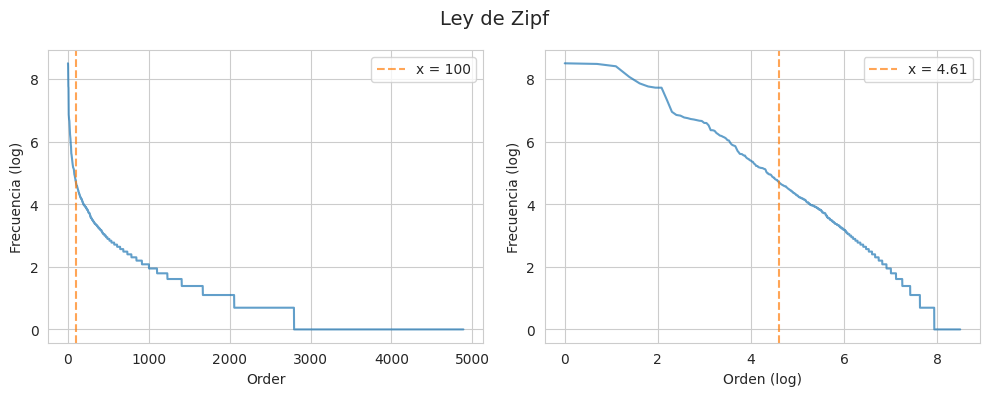

In [21]:
title = "Ley de Zipf"
order = 100

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

for i, x in enumerate(["order", "log_order"]):
    sns.lineplot(x=zipf_law[x], y=zipf_law["log_count"], ax=axs[i], alpha=.7)
    axs[i].set_ylabel("Frecuencia (log)")
    if "log" in x:
        xlabel = "Orden (log)"
        xline = math.log(order)
    else:
        xlabel = "Order"
        xline = order
    axs[i].set_xlabel(xlabel)
    axs[i].axvline(
        x=xline, color="#ff7f0e", alpha=.7, linestyle="--",
        label=f"x = {round(xline, 2)}"
    )
    axs[i].legend()

plt.suptitle(title, size=14)
plt.tight_layout()

filename = title.lower().replace(" ", "_")
plt.savefig(os.path.join(VISUALIZATIONS_PATH, filename))